In [1]:
import os, datetime, time, re, warnings, gc, json, random, yaml, umap, pickle

from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import multiprocessing
from multiprocessing import Pool

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.core.common import SettingWithCopyWarning

from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score, f1_score
from sklearn import datasets, manifold, mixture, model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import MiniBatchKMeans

from scipy.sparse import vstack, csr_matrix, save_npz, load_npz, hstack

from gensim import corpora, models, similarities
from gensim.models import Word2Vec

import lightgbm as lgb
import optuna.integration.lightgbm as tuna

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", 256)
pd.set_option("display.max_rows", 256)

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    print(f'[{title}] start')
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
class FeatureEngineering(metaclass=ABCMeta):
    BASE_DIR = "."
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self):
        self.name = self.__class__.__name__
        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_train"
        self.test_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_test"
    
    @abstractmethod
    def load_data(self):
        raise NotImplementedError

    @abstractmethod
    def create_features(self):
        raise NotImplementedError
        
    def run(self, use_columns=[], skip_columns=[]):
        with timer(self.name):
            self.load_data()
            self.replace_na(use_columns=use_columns, skip_columns=skip_columns)
            self.onehot_encode(use_columns=use_columns, skip_columns=skip_columns)
            self.create_features()
        
        return self
    
    def onehot_encode(self, use_columns=[], skip_columns=[], sparse=False):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        self.label_encode(use_columns, skip_columns)
        if sparse:
            encoder = OneHotEncoder(categories='auto', sparse=sparse, dtype='uint8').fit(pd.concat([self.train.loc[:, use_columns], self.test.loc[:, use_columns]]))
            m = 100000
            train = vstack([encoder.transform(self.train[i*m:(i+1)*m].loc[:, use_columns]) for i in range(self.train.shape[0] // m + 1)])
            test  = vstack([encoder.transform(self.test[i*m:(i+1)*m].loc[:, use_columns])  for i in range(self.test.shape[0] // m +  1)])
            save_npz(f"{self.train_file_path}.npz", train, compressed=True)
            save_npz(f"{self.test_file_path}.npz",  test,  compressed=True)
        else:
            self.train["is_train_date"] = 1
            self.test["is_train_date"]  = 0
            df = pd.concat([self.train, self.test])
            del self.train, self.test
            gc.collect()
            for col in use_columns:
                df = df.join(pd.get_dummies(df[col], prefix=col))
            
            self.train = df[df["is_train_date"]==1]
            self.test = df[df["is_train_date"]==0]
            self.train.drop(columns="is_train_date", inplace=True)
            self.test.drop(columns="is_train_date", inplace=True)
            
        return self
    
    def label_encode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        for col in use_columns:
            if df[col].dtype.name in ["object", "category"]:
                df[col] = df[col].astype(str)
                le = LabelEncoder().fit(df[col])
                df[col] = le.transform(df[col])+1
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
    
        return self
    
    def target_encode(self, col_name, target_name, min_samples_leaf=1, smoothing=1, noise_level=0):
        trn_series = self.train[col_name]
        tst_series = self.test[col_name]
        target = self.train[target_name]
        
        assert len(trn_series) == len(target)

        temp = pd.concat([trn_series, target], axis=1)
        averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
        smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
        prior = target.mean()
        averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(["mean", "count"], axis=1, inplace=True)
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=trn_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_trn_series.index = trn_series.index 
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=tst_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_tst_series.index = tst_series.index

        self.train[f"te_smoothing_{col_name}"], self.test[f"te_smoothing_{col_name}"] = self.__add_noise(ft_trn_series, noise_level), self.__add_noise(ft_tst_series, noise_level)
        
        return self
    
    def agg_transform(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"

        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
            
        for k, v in agg.items():
            if type(v) is str:
                df[f"{prefix}{k}_{v}"] = df.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    df[f"{prefix}{k}_{vv}"] = df.groupby(group)[k].transform(vv)
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def agg_transform_ratio(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"
        prefix = f"ratio_{prefix}"
        
        for k, v in agg.items():
            if type(v) is str:
                self.train[f"{prefix}{k}_{v}"] = self.train[k] / self.train.groupby(group)[k].transform(v)
                self.test[f"{prefix}{k}_{v}"] = self.test[k] / self.test.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    self.train[f"{prefix}{k}_{vv}"] = self.train[k] / self.train.groupby(group)[k].transform(vv)
                    self.test[f"{prefix}{k}_{vv}"] = self.test[k] / self.test.groupby(group)[k].transform(vv)
        
        return self
    
    def replace_na(self, use_columns=[], skip_columns=[], fill_value=-1):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)

        return self
    
    def replace_na_mode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mode().values[0])
            self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mode().values[0])

        return self
    
    def replace_na_mean(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mean())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mean())

        return self

    def replace_na_median(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].median())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].median())

        return self
    
    def calc_topic_score(self, topic_text_columns, num_topics=5):
        df = pd.concat([self.train.loc[:, topic_text_columns], self.test.loc[:, topic_text_columns]])
        
        for col in topic_text_columns:
            texts = [[word for word in document.lower().split()] for document in df[col].values]
            dictionary = corpora.Dictionary(texts)
            bow_corpus = [dictionary.doc2bow(t) for t in texts]
            lda = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=num_topics)
                        
            size = df.shape[0]
            topics = {i:[-1]*size for i in range(num_topics)}
            for i, row in enumerate(lda[bow_corpus]):
                for (topic_num, prop_topic) in row:
                    topics[topic_num][i] = prop_topic
            
            for i in range(num_topics):
                self.train[f"{col}_topic_{i}"] = topics[i][:self.train.shape[0]]
                self.test[f"{col}_topic_{i}"] = topics[i][self.train.shape[0]:]

        return self
    
    def calc_scdv_word2vec_score(self, text_col_name):
        features_num = 20
        min_word_count = 10
        context = 5
        downsampling = 1e-3
        epoch_num = 10
        clusters_num = 6
        
        df = pd.concat([self.train.loc[:, [text_col_name]], self.test.loc[:, [text_col_name]]])
        df[text_col_name] = df[text_col_name].fillna("")
        
        corpus = [self.__analyzer_cat(text) for text in df[text_col_name]]
        word2vecs = Word2Vec(sentences=corpus, iter=epoch_num, size=features_num, min_count=min_word_count, window=context, sample=downsampling)
        word_vectors = word2vecs.wv.vectors
        
        gmm = mixture.GaussianMixture(n_components=clusters_num, covariance_type='tied', max_iter=50)
        gmm.fit(word_vectors)
        
        tfidf_vectorizer = TfidfVectorizer(analyzer=self.__analyzer_cat, min_df=min_word_count)
        tfidfs = tfidf_vectorizer.fit_transform(df[text_col_name])
        
        idf_dic = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer._tfidf.idf_))
        assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict(word_vectors)))
        soft_assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict_proba(word_vectors)))
        
        word_topic_vecs = {}
        for word in assign_dic:
            word_topic_vecs[word] = np.zeros(features_num*clusters_num, dtype=np.float32)
            for i in range(0, clusters_num):
                try:
                    word_topic_vecs[word][i*features_num:(i+1)*features_num] = word2vecs.wv[word]*soft_assign_dic[word][i]*idf_dic[word]
                except:
                    continue
        
        scdvs = np.zeros((len(df[text_col_name]), clusters_num*features_num), dtype=np.float32)

        a_min = 0
        a_max = 0

        for i, text in enumerate(df[text_col_name]):
            tmp = np.zeros(clusters_num*features_num, dtype=np.float32)
            words = self.__analyzer_cat(text)
            for word in words:
                if word in word_topic_vecs:
                    tmp += word_topic_vecs[word]
            norm = np.sqrt(np.sum(tmp**2))
            if norm > 0:
                tmp /= norm
            a_min += min(tmp)
            a_max += max(tmp)
            scdvs[i] = tmp

        p = 0.04
        a_min = a_min*1.0 / len(df[text_col_name])
        a_max = a_max*1.0 / len(df[text_col_name])
        thres = (abs(a_min)+abs(a_max)) / 2
        thres *= p
        scdvs[abs(scdvs) < thres] = 0
        
        tsne_scdv = manifold.TSNE(n_components=2).fit_transform(scdvs)
        
        self.train[f"scdv_{text_col_name}_x"] = tsne_scdv[:self.train.shape[0], 0]
        self.train[f"scdv_{text_col_name}_y"] = tsne_scdv[:self.train.shape[0], 1]        
        self.test[f"scdv_{text_col_name}_x"] = tsne_scdv[self.train.shape[0]:, 0]
        self.test[f"scdv_{text_col_name}_y"] = tsne_scdv[self.train.shape[0]:, 1]
        
        return self
    
    def yeo_johnson(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        pt = PowerTransformer(method='yeo-johnson')
        pt.fit(df[num_columns])

        df[num_columns] = pt.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def umap_scaler(self, skip_columns=[]):
        self.yeo_johnson(skip_columns=skip_columns)
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]
        for col in num_columns:
            df[col] = df[col].replace(np.inf, np.nan)
            df[col].fillna(-9999, inplace=True)
        
        um = umap.UMAP()
        um.fit(df[num_columns])
        d = um.transform(df[num_columns])
        df["umap_d1"] = d[:, 0]
        df["umap_d2"] = d[:, 1]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def create_kmean_features(self, seed, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        for col in num_columns:
            df[col].fillna(-9999, inplace=True)
        X = df[num_columns]
        
        kmeans = MiniBatchKMeans(n_clusters=10, random_state=seed)
        kmeans.fit(X)

        df["k_class"] = kmeans.predict(X)
        train_distances = kmeans.transform(X)
        for i in range(10):
            df[f"k_distance_{i}"] = train_distances[:, i]
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def min_max_scaling(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        
        scaler = MinMaxScaler()
        scaler.fit(df[num_columns])
        df[num_columns] = scaler.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def two_by_two(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        targets = num_columns.copy()
        for col in num_columns:
            targets.remove(col)
            for t in targets:
                df[f"{col}_{t}_mul"] = df[col] * df[t]
                df[f"{col}_{t}_sub_left"] = df[col] / df[t]
                df[f"{col}_{t}_sub_right"] = df[t] / df[col]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def columns_1d(self):
        self.train.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.train.columns.tolist()])
        self.test.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.test.columns.tolist()])

        return self
    
    def head(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train head: {title}")
        print(self.train.loc[:, train_cols].head(limit))
        print("----------------------------")
        print(f"test head: {title}")
        print(self.test.loc[:, test_cols].head(limit))
        print("----------------------------")
        
        return self
    
    def tail(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train tail: {title}")
        print(self.train.loc[:, train_cols].tail(limit))
        print("----------------------------")
        print(f"test tail: {title}")
        print(self.test.loc[:, test_cols].tail(limit))
        print("----------------------------")
        
        return self
    
    def save(self, format="feather", index=False):
        if format == "feather":
            self.train.to_feather(f"{self.train_file_path}.ftr")
            self.test.to_feather(f"{self.test_file_path}.ftr")
        elif format == "csv":
            self.train.to_csv(f"{self.train_file_path}.csv", index=index)
            self.test.to_csv(f"{self.test_file_path}.csv", index=index)
        
        return self
    
    def __add_noise(self, series, noise_level):
        return series * (1 + noise_level * np.random.randn(len(series)))

    def __analyzer_nlp(self, text):
        stop_words = ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on']
        text = text.lower()
        text = text.replace('\n', '')
        text = text.replace('\t', '')
        text = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', text)
        text = text.split(' ')

        words = []
        for word in text:
            if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None):
                continue
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            words.append(word)

        return words

    def __analyzer_cat(self, text):
        return text.split(' ')

In [24]:
class AutoML():
    SEED = 42
    EVAL_COLUMN = "_preds"
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self, engine):
        if not isinstance(engine, FeatureEngineering): raise TypeError
        self.engine = engine
    
    def run(self, scenario):
        self.__seed_everything(AutoML.SEED)
        self.target = scenario["target"]
        self.engine.load_data()
        
        params = {
            'objective': scenario["objective"],
            'boosting_type': scenario["boosting_type"], 
            'metric': scenario["metric"],
            'n_jobs': -1,
            'seed': AutoML.SEED
        }
        tuned = self.__hyper_parameter_tuning(params)
        params = dict(params, **tuned)
        
        self.predicts, importance = self.__train(params)
        
    def greedy_forward_selection(self, base_score, base_path="./"):
        self.__seed_everything(AutoML.SEED)
        best_score = 0.0
        selected = set([])
        params = None
        scenario = None
        del self.engine.train, self.engine.test
        with open(f"{base_path}/param_{base_score}.json") as f:
            params = json.load(f)
        with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
            scenario = yaml.safe_load(yml)
        self.target = scenario["target"]
        
        train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
        test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")
        
        train_x = [f for f in train.columns if f not in self.target]
        while True:
            if len(selected) == len(train_x): break
            
            scores = []
            for col in train_x:
                if col not in selected:
                    feats = list(selected) + [col]
                    self.engine.train = train[list(feats)+[self.target]]
                    self.engine.test = test[feats]
                    self.predicts, importance = self.__train(params)
                    param_with_score = self.__evaluate(params, pd.read_csv(scenario["eval_file_path"]))
                    scores.append((col, param_with_score["score"]))
            
            b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1], reverse=True)[0]
            print(f"b_score: {b_score}")
            print(f"best_score: {best_score}")
            if b_score > best_score:
                selected.add(b_feature)
                best_score = b_score
                print(f'selected:{b_feature}')
                print(f'score:{b_score}')
            else:
                break
        
        print(f'selected features: {selected}')
        with open("selected.pkl", "wb") as fw:
            pickle.dump(selected, fw)
            
    def __do(self, command):
        if command == "fill_numeric_na":
            self.__fill_numeric_na()
        if command == "binning":
            self.__binning()
        if command == "transformation":
            self.__transformation()
        if command == "topic_encoding":
            self.__topic_encoding()
        if command == "umap":
            self.engine.umap_scaler(skip_columns=[self.target])
        if command == "kmean_features":
            self.engine.create_kmean_features(skip_columns=[self.target], seed=AutoML.SEED)
        if command == "min_max_scaling":
            self.engine.min_max_scaling(skip_columns=[self.target])
        if command == "two_by_two":
            self.engine.two_by_two(skip_columns=[self.target])
    
    def __evaluate(self, params, actuals, metric):
        calc_score_param = {"metric": metric}
        actuals[AutoML.EVAL_COLUMN] = self.predicts
        if params["objective"] == "binary":
            actuals.loc[actuals[AutoML.EVAL_COLUMN]>=0.5, AutoML.EVAL_COLUMN] = 1
            actuals.loc[actuals[AutoML.EVAL_COLUMN]<0.5, AutoML.EVAL_COLUMN] = 0
            actuals[AutoML.EVAL_COLUMN] = actuals[AutoML.EVAL_COLUMN].astype("int")
        
        score = self.__calc_score(calc_score_param, actuals[self.target], actuals[AutoML.EVAL_COLUMN])
        params["score"] = score
        print(f"Score: {score}")
        return params
    
    def __transformation(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        aggs = ["min", "max", "mean", "std"]
        for col in feats:
            if self.engine.train[col].dtype.name == "category":
                self.engine.agg_transform(group=[col], agg={f"{col}": ["count"]})
            for c in num_columns:
                if c == col: continue
                self.engine.agg_transform(group=[col], agg={f"{c}": aggs})
                for agg in aggs:
                    if self.engine.train[self.engine.train[f"{col}_{c}_{agg}"].isnull()].shape[0] > 0:
                        self.engine.train.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)
                        self.engine.test.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)

    def __fill_numeric_na(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        cat_columns = [col for col in feats if self.engine.train[col].dtype.name == "category"]
        groups = []
        for c in cat_columns:
            if self.engine.train[self.engine.train[c].isnull()].shape[0] == 0:
                if self.engine.train.groupby(c).size().shape[0] / self.engine.train.shape[0] < 0.1:
                    groups.append(c)
        for n in num_columns:
            if len(groups) > 0:
                self.engine.agg_transform(group=groups, agg={f"{n}": ["mean"]}, prefix="_tmp")
                self.engine.train[n].fillna(self.engine.train[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test[n].fillna(self.engine.test[f"_tmp_{n}_mean"], inplace=True)
                self.engine.train.drop(columns=[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test.drop(columns=[f"_tmp_{n}_mean"], inplace=True)

    def __binning(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()

        for c in num_columns:
            if df[c].unique().shape[0] > 100:
                df[f"{c}_bin"] = pd.cut(df[c], 10, labels=False)
        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __topic_encoding(self):
        self.__create_topic_text()
        self.engine.calc_topic_score(topic_text_columns=["topic_text"], num_topics=5)
        self.__drop_features(["topic_text"])

    def __create_topic_text(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()
        
        df["topic_text"] = ""
        for c in num_columns:
            df["topic_text"] = df["topic_text"].astype(str) + " " + df[c].astype(str)

        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __set_column_type(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        for col in feats:
            col_type = self.engine.train[col].dtypes
            if self.engine.train[col].unique().shape[0] < 20:
                self.engine.train[col] = self.engine.train[col].astype("category")
                self.engine.test[col] = self.engine.test[col].astype("category")

    def __drop_features(self, cols):
        feats = [f for f in self.engine.train.columns if f in cols]
        self.engine.train.drop(columns=feats, inplace=True)
        self.engine.test.drop(columns=feats, inplace=True)
    
    def __feature_selection(self, cols):
        self.engine.train = self.engine.train.loc[:, list(cols)+[self.target]]
        self.engine.test = self.engine.test.loc[:, cols]
    
    def __hyper_parameter_tuning(self, params):
        train, valid = model_selection.train_test_split(self.engine.train, test_size=0.33, random_state=AutoML.SEED, shuffle=True)
        feats = list(range(0, 119))
        
        lgb_train = tuna.Dataset(train[feats], label=train[self.target].values)
        lgb_valid = tuna.Dataset(valid[feats], label=valid[self.target].values)
        best_params, tuning_history = dict(), list()

        model = tuna.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        best_params=best_params,
                        tuning_history=tuning_history
                        )

        return best_params
    
    def __adversarial_validation(self, num_folds=5):
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        feats = [f for f in self.engine.train.columns if f not in self.target]
        train = self.engine.train[feats]
        test = self.engine.test[feats]
        train[self.target] = 0
        test[self.target] = 1
        
        df = pd.concat([train, test], ignore_index=True)
        del train, test
        gc.collect()
        
        oof_preds = np.zeros(df.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df[self.target])):
            train_x, train_y = df[feats].iloc[train_idx], df[self.target].iloc[train_idx]
            valid_x, valid_y = df[feats].iloc[valid_idx], df[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            params = {'num_leaves': 50,
                     'min_data_in_leaf': 30, 
                     'objective':'binary',
                     'max_depth': 5,
                     'learning_rate': 0.1,
                     "min_child_samples": 20,
                     "boosting": "gbdt",
                     "feature_fraction": 0.9,
                     "bagging_freq": 1,
                     "bagging_fraction": 0.9 ,
                     "bagging_seed": 44,
                     "metric": 'auc',
                     "verbosity": -1}

            model = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100
                        )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        self.__display_importances(feature_importance_df)
        
        return sum(scores)/len(scores), feature_importance_df
        
    def __train(self, params, num_folds=5, stratified=False):
        if stratified:
            folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        else:
            folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)

        feats = list(range(0, 119))
        oof_preds = np.zeros(self.engine.train.shape[0])
        sub_preds = np.zeros(self.engine.test.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(self.engine.train[feats], self.engine.train[self.target])):
            train_x, train_y = self.engine.train[feats].iloc[train_idx], self.engine.train[self.target].iloc[train_idx]
            valid_x, valid_y = self.engine.train[feats].iloc[valid_idx], self.engine.train[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            model = lgb.train(
                            params,
                            lgb_train,
                            valid_sets=[lgb_train, lgb_valid],
                            valid_names=['train', 'valid'],
                            num_boost_round=1000, 
                            early_stopping_rounds=100,
                            verbose_eval=100
                            )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)
            sub_preds += model.predict(self.engine.test[feats], num_iteration=model.best_iteration) / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        print('CV : %.6f' % (sum(scores)/len(scores)))
        self.__display_importances(feature_importance_df)

        return sub_preds, feature_importance_df
    
    def __display_importances(self, feature_importance_df_):
        all_cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
        feature_importance_df_.loc[feature_importance_df_.feature.isin(all_cols)].to_csv("feature_importance.csv", index=False)

        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

        plt.figure(figsize=(8, 10))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances.png')
    
    def __calc_score(self, params, actuals, preds):
        if params["metric"] == "rmse":
            return np.sqrt(mean_squared_error(actuals, preds))
        if params["metric"] in ["cross_entropy", "binary_logloss"]:
            return log_loss(actuals, preds)
        if params["metric"] == "auc":
            return roc_auc_score(actuals, preds)
        if params["metric"] == "f1":
            return f1_score(actuals, preds)

    def __seed_everything(self, seed):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)

In [25]:
class Sample(FeatureEngineering):
    def load_data(self):
        self.train = pd.read_pickle("./structure_train_01.pkl")
        self.test = pd.read_pickle("./structure_train_01.pkl")
        
        self.train.columns = range(0, 119)
        self.test.columns = range(0, 119)
        df = pd.read_pickle("./structure_df_01.pkl")
        self.train["k_class"] = df["k_class"]
        
        return self
    
    def create_features(self):
        return self
    
    def create_topic_text(self):
        return self

In [26]:
with open("../input/building_structure/scenario.yml", "r") as yml:
    scenario = yaml.safe_load(yml)

In [27]:
ml = AutoML(engine=Sample())

tune_feature_fraction, val_score: inf:   0%|                                                     | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.830117	valid's rmse: 1.10479
[200]	train's rmse: 0.603451	valid's rmse: 1.00998
[300]	train's rmse: 0.493192	valid's rmse: 0.95979
[400]	train's rmse: 0.426377	valid's rmse: 0.943904
[500]	train's rmse: 0.374661	valid's rmse: 0.928036
[600]	train's rmse: 0.330072	valid's rmse: 0.918782
[700]	train's rmse: 0.294678	valid's rmse: 0.91052
[800]	train's rmse: 0.265148	valid's rmse: 0.907169
[900]	train's rmse: 0.243113	valid's rmse: 0.904585
[1000]	train's rmse: 0.222781	valid's rmse: 0.901623
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.222781	valid's rmse: 0.901623


tune_feature_fraction, val_score: 0.901623:  14%|#####7                                  | 1/7 [00:01<00:07,  1.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717008	valid's rmse: 0.9947
[200]	train's rmse: 0.510542	valid's rmse: 0.90019
[300]	train's rmse: 0.412093	valid's rmse: 0.872572
[400]	train's rmse: 0.341915	valid's rmse: 0.854746
[500]	train's rmse: 0.289133	valid's rmse: 0.847038
[600]	train's rmse: 0.24977	valid's rmse: 0.847105
Early stopping, best iteration is:
[526]	train's rmse: 0.276378	valid's rmse: 0.845695


tune_feature_fraction, val_score: 0.845695:  29%|###########4                            | 2/7 [00:02<00:05,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.668418	valid's rmse: 0.949756
[200]	train's rmse: 0.463033	valid's rmse: 0.860157
[300]	train's rmse: 0.358682	valid's rmse: 0.834237
[400]	train's rmse: 0.293623	valid's rmse: 0.825614
[500]	train's rmse: 0.243511	valid's rmse: 0.822328
[600]	train's rmse: 0.207364	valid's rmse: 0.820271
[700]	train's rmse: 0.1788	valid's rmse: 0.819644
Early stopping, best iteration is:
[685]	train's rmse: 0.18371	valid's rmse: 0.818535


tune_feature_fraction, val_score: 0.818535:  43%|#################1                      | 3/7 [00:03<00:04,  1.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.638604	valid's rmse: 0.903236
[200]	train's rmse: 0.439914	valid's rmse: 0.830509
[300]	train's rmse: 0.331557	valid's rmse: 0.809347
[400]	train's rmse: 0.263428	valid's rmse: 0.803908
[500]	train's rmse: 0.211848	valid's rmse: 0.802454
Early stopping, best iteration is:
[488]	train's rmse: 0.216988	valid's rmse: 0.800255


tune_feature_fraction, val_score: 0.800255:  57%|######################8                 | 4/7 [00:04<00:03,  1.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.630275	valid's rmse: 0.854866
[200]	train's rmse: 0.429936	valid's rmse: 0.798202
[300]	train's rmse: 0.323333	valid's rmse: 0.777433
[400]	train's rmse: 0.252404	valid's rmse: 0.77582
[500]	train's rmse: 0.200848	valid's rmse: 0.774007
Early stopping, best iteration is:
[490]	train's rmse: 0.205034	valid's rmse: 0.7729


tune_feature_fraction, val_score: 0.772900:  71%|############################5           | 5/7 [00:04<00:01,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_feature_fraction, val_score: 0.763381:  86%|##################################2     | 6/7 [00:05<00:00,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.610142	valid's rmse: 0.836163
[200]	train's rmse: 0.400599	valid's rmse: 0.773164
[300]	train's rmse: 0.293563	valid's rmse: 0.767358
Early stopping, best iteration is:
[259]	train's rmse: 0.331531	valid's rmse: 0.76385


tune_num_leaves, val_score: 0.763381:   0%|                                                     | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:   5%|##2                                          | 1/20 [00:00<00:10,  1.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  10%|####5                                        | 2/20 [00:01<00:11,  1.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.747976	valid's rmse: 0.911023
[200]	train's rmse: 0.574708	valid's rmse: 0.844917
[300]	train's rmse: 0.478761	valid's rmse: 0.824784
[400]	train's rmse: 0.413457	valid's rmse: 0.816532
[500]	train's rmse: 0.365275	valid's rmse: 0.804376
[600]	train's rmse: 0.32873	valid's rmse: 0.800932
[700]	train's rmse: 0.296518	valid's rmse: 0.80116
[800]	train's rmse: 0.270285	valid's rmse: 0.796823
[900]	train's rmse: 0.248387	valid's rmse: 0.793351
Early stopping, best iteration is:
[896]	train's rmse: 0.249191	valid's rmse: 0.792789


tune_num_leaves, val_score: 0.763381:  15%|######7                                      | 3/20 [00:02<00:11,  1.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  20%|#########                                    | 4/20 [00:03<00:11,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  25%|###########2                                 | 5/20 [00:04<00:11,  1.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  30%|#############5                               | 6/20 [00:04<00:10,  1.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  35%|###############7                             | 7/20 [00:05<00:09,  1.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  40%|##################                           | 8/20 [00:06<00:09,  1.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  45%|####################2                        | 9/20 [00:07<00:08,  1.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  50%|######################                      | 10/20 [00:07<00:08,  1.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.06461	valid's rmse: 1.20275
[200]	train's rmse: 0.922679	valid's rmse: 1.08514
[300]	train's rmse: 0.843982	valid's rmse: 1.03378
[400]	train's rmse: 0.781455	valid's rmse: 1.01964
[500]	train's rmse: 0.736163	valid's rmse: 1.00604
[600]	train's rmse: 0.701868	valid's rmse: 0.999944
[700]	train's rmse: 0.668647	valid's rmse: 0.999561
Early stopping, best iteration is:
[662]	train's rmse: 0.682001	valid's rmse: 0.996619


tune_num_leaves, val_score: 0.763381:  55%|########################2                   | 11/20 [00:08<00:06,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  60%|##########################4                 | 12/20 [00:09<00:05,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  65%|############################6               | 13/20 [00:09<00:05,  1.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  70%|##############################8             | 14/20 [00:10<00:04,  1.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  75%|#################################           | 15/20 [00:11<00:03,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  80%|###################################2        | 16/20 [00:12<00:02,  1.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  85%|#####################################4      | 17/20 [00:13<00:02,  1.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  90%|#######################################6    | 18/20 [00:13<00:01,  1.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381:  95%|#########################################8  | 19/20 [00:14<00:00,  1.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_num_leaves, val_score: 0.763381: 100%|############################################| 20/20 [00:15<00:00,  1.31it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:   0%|                              | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.18891	valid's rmse: 1.1909
[200]	train's rmse: 0.986267	valid's rmse: 1.11943
[300]	train's rmse: 0.864312	valid's rmse: 1.07915
[400]	train's rmse: 0.766096	valid's rmse: 1.07194
[500]	train's rmse: 0.70184	valid's rmse: 1.02265
[600]	train's rmse: 0.648452	valid's rmse: 1.01942
[700]	train's rmse: 0.602117	valid's rmse: 1.02996
Early stopping, best iteration is:
[662]	train's rmse: 0.617704	valid's rmse: 0.988044


tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  10%|##2                   | 1/10 [00:00<00:05,  1.71it/s][I 2020-03-18 13:03:06,293] Finished trial#0 resulted in value: 0.9880441144545407. Current best value is 0.9880441144545407 with parameters: {'bagging_fraction': 0.43211646497991746, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  10%|##2                   | 1/10 [00:00<00:05,  1.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.752211	valid's rmse: 0.959612
[200]	train's rmse: 0.580519	valid's rmse: 0.898353
[300]	train's rmse: 0.479832	valid's rmse: 0.865544
[400]	train's rmse: 0.413075	valid's rmse: 0.855456
[500]	train's rmse: 0.356506	valid's rmse: 0.843602
[600]	train's rmse: 0.310064	valid's rmse: 0.842531
Early stopping, best iteration is:
[502]	train's rmse: 0.355204	valid's rmse: 0.84132


tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  20%|####4                 | 2/10 [00:01<00:04,  1.65it/s][I 2020-03-18 13:03:06,958] Finished trial#1 resulted in value: 0.8413198259232945. Current best value is 0.8413198259232945 with parameters: {'bagging_fraction': 0.6829043317024043, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  20%|####4                 | 2/10 [00:01<00:04,  1.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.690202	valid's rmse: 0.90167
[200]	train's rmse: 0.488128	valid's rmse: 0.83706
[300]	train's rmse: 0.379701	valid's rmse: 0.804162
[400]	train's rmse: 0.304796	valid's rmse: 0.794405
[500]	train's rmse: 0.250779	valid's rmse: 0.784461
[600]	train's rmse: 0.208119	valid's rmse: 0.780577
[700]	train's rmse: 0.176153	valid's rmse: 0.778829
[800]	train's rmse: 0.149772	valid's rmse: 0.782938
Early stopping, best iteration is:
[700]	train's rmse: 0.176153	valid's rmse: 0.778829


tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  30%|######6               | 3/10 [00:02<00:04,  1.41it/s][I 2020-03-18 13:03:07,919] Finished trial#2 resulted in value: 0.7788285276914089. Current best value is 0.7788285276914089 with parameters: {'bagging_fraction': 0.8303849484265573, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  30%|######6               | 3/10 [00:02<00:04,  1.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.82668	valid's rmse: 0.989118
[200]	train's rmse: 0.640211	valid's rmse: 0.932643
[300]	train's rmse: 0.536584	valid's rmse: 0.908333
[400]	train's rmse: 0.468319	valid's rmse: 0.896587
[500]	train's rmse: 0.412627	valid's rmse: 0.883604
[600]	train's rmse: 0.367086	valid's rmse: 0.883239
Early stopping, best iteration is:
[540]	train's rmse: 0.394021	valid's rmse: 0.879359


tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  40%|########8             | 4/10 [00:02<00:04,  1.42it/s][I 2020-03-18 13:03:08,606] Finished trial#3 resulted in value: 0.8793588107634605. Current best value is 0.7788285276914089 with parameters: {'bagging_fraction': 0.8303849484265573, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  40%|########8             | 4/10 [00:03<00:04,  1.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.708592	valid's rmse: 0.923696
[200]	train's rmse: 0.518527	valid's rmse: 0.849458
[300]	train's rmse: 0.414002	valid's rmse: 0.830107
[400]	train's rmse: 0.341224	valid's rmse: 0.813209
[500]	train's rmse: 0.285909	valid's rmse: 0.808737
[600]	train's rmse: 0.24009	valid's rmse: 0.809182
[700]	train's rmse: 0.207895	valid's rmse: 0.804586
[800]	train's rmse: 0.178981	valid's rmse: 0.806206
Early stopping, best iteration is:
[738]	train's rmse: 0.196258	valid's rmse: 0.802363


tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  50%|###########           | 5/10 [00:03<00:03,  1.30it/s][I 2020-03-18 13:03:09,547] Finished trial#4 resulted in value: 0.8023631553724085. Current best value is 0.7788285276914089 with parameters: {'bagging_fraction': 0.8303849484265573, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  50%|###########           | 5/10 [00:03<00:03,  1.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.675009	valid's rmse: 0.878973
[200]	train's rmse: 0.488191	valid's rmse: 0.828445
[300]	train's rmse: 0.37989	valid's rmse: 0.796098
[400]	train's rmse: 0.30324	valid's rmse: 0.783892
[500]	train's rmse: 0.249499	valid's rmse: 0.778186
[600]	train's rmse: 0.207181	valid's rmse: 0.778582
[700]	train's rmse: 0.174614	valid's rmse: 0.774768
Early stopping, best iteration is:
[697]	train's rmse: 0.175692	valid's rmse: 0.774515


tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  60%|#############2        | 6/10 [00:04<00:03,  1.19it/s][I 2020-03-18 13:03:10,554] Finished trial#5 resulted in value: 0.7745152081062727. Current best value is 0.7745152081062727 with parameters: {'bagging_fraction': 0.8403146609351392, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  60%|#############2        | 6/10 [00:04<00:03,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.30609	valid's rmse: 1.30871
[200]	train's rmse: 1.09368	valid's rmse: 1.20969
[300]	train's rmse: 0.962741	valid's rmse: 1.15056
[400]	train's rmse: 0.878173	valid's rmse: 1.13209
[500]	train's rmse: 0.79688	valid's rmse: 1.13036
Early stopping, best iteration is:
[413]	train's rmse: 0.869658	valid's rmse: 1.12214


tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  70%|###############4      | 7/10 [00:05<00:02,  1.35it/s][I 2020-03-18 13:03:11,061] Finished trial#6 resulted in value: 1.1221361262560283. Current best value is 0.7745152081062727 with parameters: {'bagging_fraction': 0.8403146609351392, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  70%|###############4      | 7/10 [00:05<00:02,  1.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.879299	valid's rmse: 0.985092
[200]	train's rmse: 0.641992	valid's rmse: 0.874995
[300]	train's rmse: 0.529563	valid's rmse: 0.846695
[400]	train's rmse: 0.458248	valid's rmse: 0.830817
Early stopping, best iteration is:
[387]	train's rmse: 0.466777	valid's rmse: 0.826843


tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  80%|#################6    | 8/10 [00:05<00:01,  1.44it/s][I 2020-03-18 13:03:11,633] Finished trial#7 resulted in value: 0.8268433515829214. Current best value is 0.7745152081062727 with parameters: {'bagging_fraction': 0.8403146609351392, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  80%|#################6    | 8/10 [00:06<00:01,  1.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.890118	valid's rmse: 0.99683
[200]	train's rmse: 0.657442	valid's rmse: 0.879958
[300]	train's rmse: 0.53566	valid's rmse: 0.852638
[400]	train's rmse: 0.465007	valid's rmse: 0.836655
Early stopping, best iteration is:
[388]	train's rmse: 0.47234	valid's rmse: 0.828064


tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  90%|###################8  | 9/10 [00:06<00:00,  1.52it/s][I 2020-03-18 13:03:12,211] Finished trial#8 resulted in value: 0.8280641736561583. Current best value is 0.7745152081062727 with parameters: {'bagging_fraction': 0.8403146609351392, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381:  90%|###################8  | 9/10 [00:06<00:00,  1.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.713457	valid's rmse: 0.922264
[200]	train's rmse: 0.52671	valid's rmse: 0.852819
[300]	train's rmse: 0.426147	valid's rmse: 0.825551
[400]	train's rmse: 0.358199	valid's rmse: 0.820955
[500]	train's rmse: 0.304414	valid's rmse: 0.812911
[600]	train's rmse: 0.262944	valid's rmse: 0.8106
Early stopping, best iteration is:
[507]	train's rmse: 0.300822	valid's rmse: 0.807545


tune_bagging_fraction_and_bagging_freq, val_score: 0.763381: 100%|#####################| 10/10 [00:07<00:00,  1.48it/s][I 2020-03-18 13:03:12,930] Finished trial#9 resulted in value: 0.8075449954928322. Current best value is 0.7745152081062727 with parameters: {'bagging_fraction': 0.8403146609351392, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.763381: 100%|#####################| 10/10 [00:07<00:00,  1.37it/s]
tune_feature_fraction, val_score: 0.763381:   0%|                                                | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.630275	valid's rmse: 0.854866
[200]	train's rmse: 0.429936	valid's rmse: 0.798202
[300]	train's rmse: 0.323333	valid's rmse: 0.777433
[400]	train's rmse: 0.252404	valid's rmse: 0.77582
[500]	train's rmse: 0.200848	valid's rmse: 0.774007
Early stopping, best iteration is:
[490]	train's rmse: 0.205034	valid's rmse: 0.7729


tune_feature_fraction, val_score: 0.763381:  17%|######6                                 | 1/6 [00:00<00:02,  1.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_feature_fraction, val_score: 0.763381:  33%|#############3                          | 2/6 [00:01<00:02,  1.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.622742	valid's rmse: 0.852623
[200]	train's rmse: 0.418567	valid's rmse: 0.794514
[300]	train's rmse: 0.314443	valid's rmse: 0.773602
[400]	train's rmse: 0.242575	valid's rmse: 0.764055
Early stopping, best iteration is:
[398]	train's rmse: 0.244022	valid's rmse: 0.763381


tune_feature_fraction, val_score: 0.763381:  50%|####################                    | 3/6 [00:01<00:01,  1.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.587526	valid's rmse: 0.833595
[200]	train's rmse: 0.393671	valid's rmse: 0.779861
[300]	train's rmse: 0.29286	valid's rmse: 0.770219
[400]	train's rmse: 0.229612	valid's rmse: 0.762937
[500]	train's rmse: 0.183869	valid's rmse: 0.763722
Early stopping, best iteration is:
[444]	train's rmse: 0.20707	valid's rmse: 0.761955


tune_feature_fraction, val_score: 0.761955:  67%|##########################6             | 4/6 [00:02<00:01,  1.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.587526	valid's rmse: 0.833595
[200]	train's rmse: 0.393671	valid's rmse: 0.779861
[300]	train's rmse: 0.29286	valid's rmse: 0.770219
[400]	train's rmse: 0.229612	valid's rmse: 0.762937
[500]	train's rmse: 0.183869	valid's rmse: 0.763722
Early stopping, best iteration is:
[444]	train's rmse: 0.20707	valid's rmse: 0.761955


tune_feature_fraction, val_score: 0.761955:  83%|#################################3      | 5/6 [00:03<00:00,  1.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.610142	valid's rmse: 0.836163
[200]	train's rmse: 0.400599	valid's rmse: 0.773164
[300]	train's rmse: 0.293563	valid's rmse: 0.767358
Early stopping, best iteration is:
[259]	train's rmse: 0.331531	valid's rmse: 0.76385


tune_feature_fraction, val_score: 0.761955: 100%|########################################| 6/6 [00:03<00:00,  1.56it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.761955:   0%|                                        | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.602989	valid's rmse: 0.831706
[200]	train's rmse: 0.39744	valid's rmse: 0.787701
[300]	train's rmse: 0.297307	valid's rmse: 0.771261
[400]	train's rmse: 0.231887	valid's rmse: 0.762535
[500]	train's rmse: 0.185208	valid's rmse: 0.76105
Early stopping, best iteration is:
[424]	train's rmse: 0.218112	valid's rmse: 0.760386


tune_lambda_l1_and_lambda_l2, val_score: 0.760386:   5%|#6                              | 1/20 [00:00<00:10,  1.89it/s][I 2020-03-18 13:03:17,452] Finished trial#0 resulted in value: 0.7603856416084017. Current best value is 0.7603856416084017 with parameters: {'lambda_l1': 1.1505300412454787e-06, 'lambda_l2': 0.0002715529204049868}.
tune_lambda_l1_and_lambda_l2, val_score: 0.760386:   5%|#6                              | 1/20 [00:00<00:10,  1.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.596889	valid's rmse: 0.84464
[200]	train's rmse: 0.397566	valid's rmse: 0.793028
[300]	train's rmse: 0.294859	valid's rmse: 0.776913
[400]	train's rmse: 0.229114	valid's rmse: 0.77023
[500]	train's rmse: 0.182723	valid's rmse: 0.767943
[600]	train's rmse: 0.149341	valid's rmse: 0.772763
Early stopping, best iteration is:
[501]	train's rmse: 0.182249	valid's rmse: 0.767739


tune_lambda_l1_and_lambda_l2, val_score: 0.760386:  10%|###2                            | 2/20 [00:01<00:10,  1.64it/s][I 2020-03-18 13:03:18,227] Finished trial#1 resulted in value: 0.7677394026996059. Current best value is 0.7603856416084017 with parameters: {'lambda_l1': 1.1505300412454787e-06, 'lambda_l2': 0.0002715529204049868}.
tune_lambda_l1_and_lambda_l2, val_score: 0.760386:  10%|###2                            | 2/20 [00:01<00:10,  1.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.600862	valid's rmse: 0.837042
[200]	train's rmse: 0.40598	valid's rmse: 0.78372
[300]	train's rmse: 0.296943	valid's rmse: 0.765395
[400]	train's rmse: 0.227874	valid's rmse: 0.75673
[500]	train's rmse: 0.18013	valid's rmse: 0.751785
[600]	train's rmse: 0.14608	valid's rmse: 0.754787
Early stopping, best iteration is:
[502]	train's rmse: 0.179316	valid's rmse: 0.751564


tune_lambda_l1_and_lambda_l2, val_score: 0.751564:  15%|####8                           | 3/20 [00:02<00:10,  1.55it/s][I 2020-03-18 13:03:18,953] Finished trial#2 resulted in value: 0.7515637425230617. Current best value is 0.7515637425230617 with parameters: {'lambda_l1': 1.5872507444779662e-08, 'lambda_l2': 0.005528705146888955}.
tune_lambda_l1_and_lambda_l2, val_score: 0.751564:  15%|####8                           | 3/20 [00:02<00:10,  1.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.606149	valid's rmse: 0.831663
[200]	train's rmse: 0.400845	valid's rmse: 0.770189
[300]	train's rmse: 0.303324	valid's rmse: 0.748414
[400]	train's rmse: 0.237737	valid's rmse: 0.743877
Early stopping, best iteration is:
[392]	train's rmse: 0.242244	valid's rmse: 0.742811


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  20%|######4                         | 4/20 [00:02<00:09,  1.60it/s][I 2020-03-18 13:03:19,544] Finished trial#3 resulted in value: 0.7428112480377671. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  20%|######4                         | 4/20 [00:02<00:09,  1.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.606877	valid's rmse: 0.839453
[200]	train's rmse: 0.410283	valid's rmse: 0.787396
[300]	train's rmse: 0.312477	valid's rmse: 0.774573
[400]	train's rmse: 0.251116	valid's rmse: 0.771699
[500]	train's rmse: 0.20527	valid's rmse: 0.771502
Early stopping, best iteration is:
[425]	train's rmse: 0.23749	valid's rmse: 0.77012


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  25%|########                        | 5/20 [00:03<00:09,  1.60it/s][I 2020-03-18 13:03:20,174] Finished trial#4 resulted in value: 0.7701204524916602. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  25%|########                        | 5/20 [00:03<00:09,  1.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.590168	valid's rmse: 0.83528
[200]	train's rmse: 0.386582	valid's rmse: 0.781803
[300]	train's rmse: 0.285526	valid's rmse: 0.768904
[400]	train's rmse: 0.222166	valid's rmse: 0.765159
[500]	train's rmse: 0.176601	valid's rmse: 0.76341
[600]	train's rmse: 0.140439	valid's rmse: 0.762321
Early stopping, best iteration is:
[543]	train's rmse: 0.159524	valid's rmse: 0.761352


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  30%|#########6                      | 6/20 [00:04<00:09,  1.48it/s][I 2020-03-18 13:03:20,965] Finished trial#5 resulted in value: 0.7613522042872454. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  30%|#########6                      | 6/20 [00:04<00:09,  1.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.624964	valid's rmse: 0.842736
[200]	train's rmse: 0.421523	valid's rmse: 0.777415
[300]	train's rmse: 0.315102	valid's rmse: 0.753577
[400]	train's rmse: 0.244575	valid's rmse: 0.750899
[500]	train's rmse: 0.196383	valid's rmse: 0.746668
Early stopping, best iteration is:
[473]	train's rmse: 0.207649	valid's rmse: 0.745355


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  35%|###########2                    | 7/20 [00:04<00:08,  1.48it/s][I 2020-03-18 13:03:21,631] Finished trial#6 resulted in value: 0.7453547326946461. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  35%|###########2                    | 7/20 [00:04<00:08,  1.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.953044	valid's rmse: 1.04578
[200]	train's rmse: 0.949241	valid's rmse: 1.04171
Early stopping, best iteration is:
[116]	train's rmse: 0.949656	valid's rmse: 1.04161


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  40%|############8                   | 8/20 [00:04<00:06,  1.81it/s][I 2020-03-18 13:03:21,892] Finished trial#7 resulted in value: 1.0416117286938174. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  40%|############8                   | 8/20 [00:05<00:06,  1.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.5883	valid's rmse: 0.832659
[200]	train's rmse: 0.387926	valid's rmse: 0.789372
[300]	train's rmse: 0.287224	valid's rmse: 0.775267
[400]	train's rmse: 0.221415	valid's rmse: 0.770279
[500]	train's rmse: 0.177199	valid's rmse: 0.768941
[600]	train's rmse: 0.143928	valid's rmse: 0.770504
Early stopping, best iteration is:
[565]	train's rmse: 0.154283	valid's rmse: 0.768242


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  45%|##############4                 | 9/20 [00:05<00:06,  1.60it/s][I 2020-03-18 13:03:22,701] Finished trial#8 resulted in value: 0.7682423962277642. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  45%|##############4                 | 9/20 [00:05<00:06,  1.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.595349	valid's rmse: 0.839646
[200]	train's rmse: 0.391846	valid's rmse: 0.785513
[300]	train's rmse: 0.287428	valid's rmse: 0.764576
[400]	train's rmse: 0.223804	valid's rmse: 0.761891
Early stopping, best iteration is:
[366]	train's rmse: 0.242316	valid's rmse: 0.760268


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  50%|###############5               | 10/20 [00:06<00:06,  1.60it/s][I 2020-03-18 13:03:23,324] Finished trial#9 resulted in value: 0.7602676816634779. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  50%|###############5               | 10/20 [00:06<00:06,  1.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.594569	valid's rmse: 0.834265
[200]	train's rmse: 0.396409	valid's rmse: 0.786824
[300]	train's rmse: 0.293737	valid's rmse: 0.769198
[400]	train's rmse: 0.226242	valid's rmse: 0.761975
[500]	train's rmse: 0.180167	valid's rmse: 0.762721
Early stopping, best iteration is:
[478]	train's rmse: 0.189447	valid's rmse: 0.759983


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  55%|#################              | 11/20 [00:07<00:05,  1.53it/s][I 2020-03-18 13:03:24,042] Finished trial#10 resulted in value: 0.7599833308874472. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  55%|#################              | 11/20 [00:07<00:05,  1.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.669249	valid's rmse: 0.871192
[200]	train's rmse: 0.466481	valid's rmse: 0.811125
[300]	train's rmse: 0.355332	valid's rmse: 0.788735
[400]	train's rmse: 0.283646	valid's rmse: 0.781829
[500]	train's rmse: 0.231385	valid's rmse: 0.780353
[600]	train's rmse: 0.189613	valid's rmse: 0.778952
[700]	train's rmse: 0.158224	valid's rmse: 0.779153
Early stopping, best iteration is:
[652]	train's rmse: 0.172249	valid's rmse: 0.777388


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  60%|##################5            | 12/20 [00:08<00:05,  1.38it/s][I 2020-03-18 13:03:24,937] Finished trial#11 resulted in value: 0.7773884291169659. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  60%|##################5            | 12/20 [00:08<00:05,  1.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.669106	valid's rmse: 0.868621
[200]	train's rmse: 0.458525	valid's rmse: 0.800622
[300]	train's rmse: 0.345768	valid's rmse: 0.772934
[400]	train's rmse: 0.271896	valid's rmse: 0.764363
[500]	train's rmse: 0.220053	valid's rmse: 0.759385
Early stopping, best iteration is:
[476]	train's rmse: 0.231048	valid's rmse: 0.757754


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  65%|####################1          | 13/20 [00:08<00:05,  1.38it/s][I 2020-03-18 13:03:25,662] Finished trial#12 resulted in value: 0.7577539369239867. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  65%|####################1          | 13/20 [00:08<00:05,  1.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.647201	valid's rmse: 0.867677
[200]	train's rmse: 0.461661	valid's rmse: 0.811828
[300]	train's rmse: 0.378229	valid's rmse: 0.797213
[400]	train's rmse: 0.323654	valid's rmse: 0.792292
Early stopping, best iteration is:
[384]	train's rmse: 0.330501	valid's rmse: 0.791079


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  70%|#####################7         | 14/20 [00:09<00:04,  1.44it/s][I 2020-03-18 13:03:26,262] Finished trial#13 resulted in value: 0.7910789092760615. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  70%|#####################7         | 14/20 [00:09<00:04,  1.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.596394	valid's rmse: 0.832561
[200]	train's rmse: 0.393167	valid's rmse: 0.783288
[300]	train's rmse: 0.292616	valid's rmse: 0.762739
[400]	train's rmse: 0.225698	valid's rmse: 0.760937
[500]	train's rmse: 0.178672	valid's rmse: 0.757577
Early stopping, best iteration is:
[488]	train's rmse: 0.183674	valid's rmse: 0.756925


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  75%|#######################2       | 15/20 [00:10<00:03,  1.45it/s][I 2020-03-18 13:03:26,952] Finished trial#14 resulted in value: 0.756925477198871. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  75%|#######################2       | 15/20 [00:10<00:03,  1.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.590383	valid's rmse: 0.846964
[200]	train's rmse: 0.398098	valid's rmse: 0.799523
[300]	train's rmse: 0.292184	valid's rmse: 0.781581
[400]	train's rmse: 0.225757	valid's rmse: 0.775276
[500]	train's rmse: 0.180131	valid's rmse: 0.775251
Early stopping, best iteration is:
[458]	train's rmse: 0.197525	valid's rmse: 0.773509


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  80%|########################8      | 16/20 [00:10<00:02,  1.43it/s][I 2020-03-18 13:03:27,685] Finished trial#15 resulted in value: 0.7735088336135932. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  80%|########################8      | 16/20 [00:10<00:02,  1.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.603349	valid's rmse: 0.841966
[200]	train's rmse: 0.396326	valid's rmse: 0.795587
[300]	train's rmse: 0.29329	valid's rmse: 0.776198
[400]	train's rmse: 0.230744	valid's rmse: 0.771782
[500]	train's rmse: 0.183791	valid's rmse: 0.770799
Early stopping, best iteration is:
[478]	train's rmse: 0.192921	valid's rmse: 0.770398


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  85%|##########################3    | 17/20 [00:11<00:02,  1.42it/s][I 2020-03-18 13:03:28,419] Finished trial#16 resulted in value: 0.7703976046515326. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  85%|##########################3    | 17/20 [00:11<00:02,  1.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.610099	valid's rmse: 0.84518
[200]	train's rmse: 0.413936	valid's rmse: 0.785518
[300]	train's rmse: 0.316243	valid's rmse: 0.770822
[400]	train's rmse: 0.254766	valid's rmse: 0.768082
[500]	train's rmse: 0.213087	valid's rmse: 0.766834
[600]	train's rmse: 0.182609	valid's rmse: 0.767546
Early stopping, best iteration is:
[552]	train's rmse: 0.196234	valid's rmse: 0.765781


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  90%|###########################9   | 18/20 [00:12<00:01,  1.38it/s][I 2020-03-18 13:03:29,178] Finished trial#17 resulted in value: 0.7657805219102153. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  90%|###########################9   | 18/20 [00:12<00:01,  1.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.596889	valid's rmse: 0.84464
[200]	train's rmse: 0.392491	valid's rmse: 0.791082
[300]	train's rmse: 0.294749	valid's rmse: 0.768527
[400]	train's rmse: 0.22798	valid's rmse: 0.761211
Early stopping, best iteration is:
[379]	train's rmse: 0.241135	valid's rmse: 0.759809


tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  95%|#############################4 | 19/20 [00:12<00:00,  1.45it/s][I 2020-03-18 13:03:29,790] Finished trial#18 resulted in value: 0.7598094456377075. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811:  95%|#############################4 | 19/20 [00:13<00:00,  1.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.606319	valid's rmse: 0.83768
[200]	train's rmse: 0.404847	valid's rmse: 0.779272
[300]	train's rmse: 0.301894	valid's rmse: 0.763409
[400]	train's rmse: 0.237651	valid's rmse: 0.760209
[500]	train's rmse: 0.191321	valid's rmse: 0.757105
[600]	train's rmse: 0.156643	valid's rmse: 0.758221
Early stopping, best iteration is:
[512]	train's rmse: 0.186313	valid's rmse: 0.756439


tune_lambda_l1_and_lambda_l2, val_score: 0.742811: 100%|###############################| 20/20 [00:13<00:00,  1.40it/s][I 2020-03-18 13:03:30,563] Finished trial#19 resulted in value: 0.7564389129522415. Current best value is 0.7428112480377671 with parameters: {'lambda_l1': 0.04014538631290826, 'lambda_l2': 2.912312881036379e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.742811: 100%|###############################| 20/20 [00:13<00:00,  1.45it/s]
tune_min_child_samples, val_score: 0.742811:   0%|                                               | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.146297	valid's rmse: 0.722384
Early stopping, best iteration is:
[57]	train's rmse: 0.237961	valid's rmse: 0.714999


tune_min_child_samples, val_score: 0.714999:  20%|#######8                               | 1/5 [00:00<00:00,  6.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.296748	valid's rmse: 0.707478
[200]	train's rmse: 0.170728	valid's rmse: 0.709086
Early stopping, best iteration is:
[119]	train's rmse: 0.263646	valid's rmse: 0.70492


tune_min_child_samples, val_score: 0.704920:  40%|###############6                       | 2/5 [00:00<00:00,  4.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.708182	valid's rmse: 0.887013
[200]	train's rmse: 0.519908	valid's rmse: 0.818309
[300]	train's rmse: 0.403921	valid's rmse: 0.78764
[400]	train's rmse: 0.331515	valid's rmse: 0.781471
[500]	train's rmse: 0.278157	valid's rmse: 0.778868
[600]	train's rmse: 0.239897	valid's rmse: 0.781333
Early stopping, best iteration is:
[531]	train's rmse: 0.264369	valid's rmse: 0.777804


tune_min_child_samples, val_score: 0.704920:  60%|#######################4               | 3/5 [00:01<00:00,  2.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.19136	valid's rmse: 1.19296
[200]	train's rmse: 1.02729	valid's rmse: 1.12193
[300]	train's rmse: 0.934858	valid's rmse: 1.09723
[400]	train's rmse: 0.870333	valid's rmse: 1.0817
Early stopping, best iteration is:
[387]	train's rmse: 0.878032	valid's rmse: 1.0812


tune_min_child_samples, val_score: 0.704920:  80%|###############################2       | 4/5 [00:02<00:00,  2.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.88576	valid's rmse: 1.88119
[200]	train's rmse: 1.8275	valid's rmse: 1.87301
[300]	train's rmse: 1.78547	valid's rmse: 1.87251
Early stopping, best iteration is:
[221]	train's rmse: 1.81701	valid's rmse: 1.86506


tune_min_child_samples, val_score: 0.704920: 100%|#######################################| 5/5 [00:02<00:00,  2.10it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.26323	valid's rmse: 0.777389
Early stopping, best iteration is:
[51]	train's rmse: 0.418121	valid's rmse: 0.762902
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.316465	valid's rmse: 0.629983
[200]	train's rmse: 0.178699	valid's rmse: 0.623664
Early stopping, best iteration is:
[117]	train's rmse: 0.284551	valid's rmse: 0.621304
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.306364	valid's rmse: 0.760874
[200]	train's rmse: 0.178189	valid's rmse: 0.74062
[300]	train's rmse: 0.118347	valid's rmse: 0.738241
Early stopping, best iteration is:
[285]	train's rmse: 0.124702	valid's rmse: 0.737039
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.268337	valid's rmse: 0.893566
[200]	train's rmse: 0.152101	valid's rmse: 0.897839
Early stopping, best iteration is:
[116]	train's rmse: 0.245467	valid's rmse: 

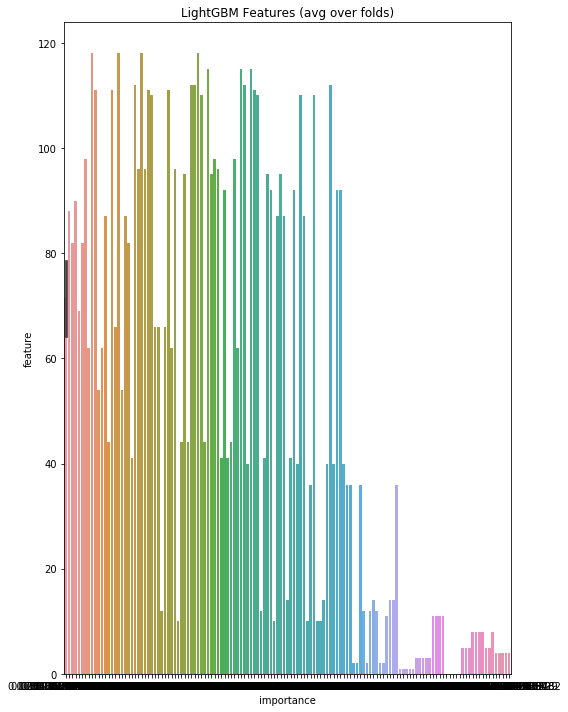

In [28]:
ml.run(scenario)

In [ ]:
ml.engine.train.shape

In [ ]:
ml.predicts

In [ ]:
actual = pd.read_csv("../input/vortex/vortex_actual_05.csv")
actual["pred"] = ml.predicts
actual.to_csv("actual_05.csv")

In [ ]:
with open("selected.pkl", "rb") as f:
    hoge = pickle.load(f)

In [ ]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
df = pd.concat([train, test])

In [ ]:
train.info()

In [ ]:
train.head()

In [ ]:
scaler = StandardScaler()
scaler.fit(train[["Age", "Fare"]])

train[["Age", "Fare"]] = scaler.transform(train[["Age", "Fare"]])
train["Age"].fillna(-9999, inplace=True)
train["Fare"].fillna(-9999, inplace=True)

In [ ]:
import umap

um = umap.UMAP()
um.fit(train[["Age", "Fare"]])

d = um.transform(train[["Age", "Fare"]])

In [ ]:
d[:, 1]

In [ ]:
train.head()

In [ ]:
train[["Age", "Fare"]] = train[["Age", "Fare"]].replace(np.inf, np.nan)

In [ ]:
df = pd.concat([ml.engine.train, ml.engine.test], ignore_index=True)
skip_columns = ["Survived"]

In [ ]:
feats = [f for f in df.columns if f not in skip_columns]
num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]

In [ ]:
num_columns

In [ ]:
for col in num_columns:
    df[col] = df[col].replace(np.inf, np.nan)
    df[col].fillna(-9999, inplace=True)

In [ ]:
um = umap.UMAP()
um.fit(df[num_columns])
df[num_columns] = um.transform(df[num_columns])

In [ ]:
df[num_columns].shape

In [ ]:
um.transform(df[num_columns])

In [ ]:
base_path = "./"
base_score = 0.7681353456669913

In [ ]:
best_score = 0.0
selected = set([])
params = None
scenario = None
with open(f"{base_path}/param_{base_score}.json") as f:
    params = json.load(f)
with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
    scenario = yaml.safe_load(yml)

train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")

train_x = [f for f in train.columns if f not in ["Survived"]]

In [ ]:
scores = []
for col in train_x:
    if col not in selected:
        feats = list(selected) + [col]
        param_with_score = 1
        scores.append((col, param_with_score))

In [ ]:
b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1])[0]
if b_score > best_score:
    selected.add(b_feature)
    best_score = b_score
    print(f'selected:{b_feature}')
    print(f'score:{b_score}')
else:
    break